In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.special import softmax
from easydict import EasyDict
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D

In [ ]:
#We are using the cleverhans package which contains many adversarial attack algorithms
#See https://github.com/cleverhans-lab/cleverhans for more info

In [2]:
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.tf2.utils import optimize_linear, compute_gradient

In [2]:
#defining the model

In [3]:
class Net(Model):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = Conv2D(64, 8, strides=(2, 2), activation="relu", padding="same")
        self.conv2 = Conv2D(128, 6, strides=(2, 2), activation="relu", padding="valid")
        self.conv3 = Conv2D(128, 5, strides=(1, 1), activation="relu", padding="valid")
        self.dropout = Dropout(0.25)
        self.flatten = Flatten()
        self.dense1 = Dense(128, activation="relu")
        self.dense2 = Dense(10)

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.dense1(x)
        return self.dense2(x)

In [ ]:
#loading the mnist data of handwritten numerals
#60000 = 468x128 + 1x96 

In [4]:
def ld_mnist():
    """Load training and test data."""

    def convert_types(image, label):
        image = tf.cast(image, tf.float32)
        image /= 255
        return image, label

    dataset, info = tfds.load(
        "mnist", data_dir="gs://tfds-data/datasets", with_info=True, as_supervised=True
    )
    mnist_train, mnist_test = dataset["train"], dataset["test"]
    mnist_train = mnist_train.map(convert_types).shuffle(10000).batch(128)
    mnist_test = mnist_test.map(convert_types).batch(128)
    return EasyDict(train=mnist_train, test=mnist_test)

In [5]:
data = ld_mnist()
model = Net()
loss_object = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.optimizers.Adam(learning_rate=0.001)

In [ ]:
#defining training metric and the training step function

In [6]:
train_loss = tf.metrics.Mean(name="train_loss")
test_acc_clean = tf.metrics.SparseCategoricalAccuracy()
test_acc_fgsm = tf.metrics.SparseCategoricalAccuracy()
test_acc_pgd = tf.metrics.SparseCategoricalAccuracy()

In [7]:
@tf.function
def train_step(x, y):
      with tf.GradientTape() as tape:
           predictions = model(x)
           loss = loss_object(y, predictions)
      gradients = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(gradients, model.trainable_variables))
      train_loss(loss)

In [ ]:
#parameters for training and adversarial example generation

In [8]:
nb_epochs = 6
eps = 0.2
adv_train = False
loss_fn = tf.nn.sparse_softmax_cross_entropy_with_logits
targeted=False
norm = np.inf

In [ ]:
#training

In [9]:
for epoch in range(nb_epochs):
        # keras like display of progress
        progress_bar_train = tf.keras.utils.Progbar(60000)
        for (x, y) in data.train:
            if adv_train:
                # Replace clean example with adversarial example for adversarial training
                x = projected_gradient_descent(model, x, eps, 0.01, 40, np.inf)
            train_step(x, y)
            progress_bar_train.add(x.shape[0], values=[("loss", train_loss.result())])

60000/60000 [==============================] - 92s 2ms/step - loss: 0.0603: 0s - loss: 0.06


In [ ]:
#adversarial examples using fast gradient sign (FGM)

The test label is 2


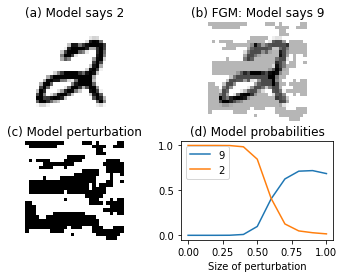

The test label is 2


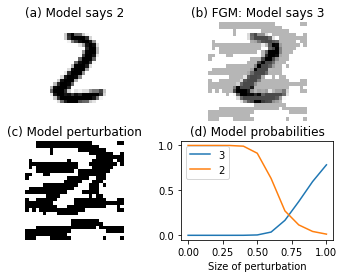

The test label is 3


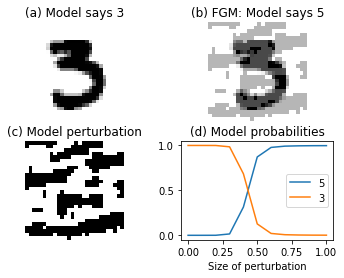

The test label is 6


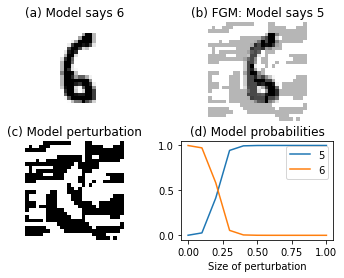

The test label is 1


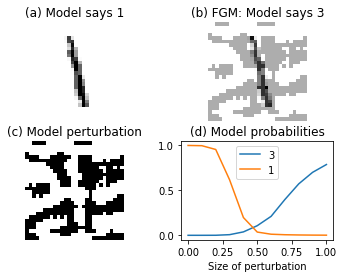

The test label is 8


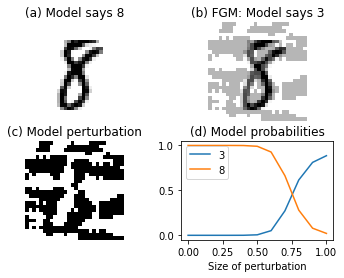

The test label is 8


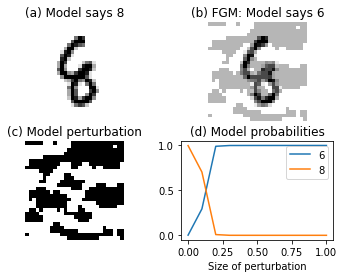

The test label is 1


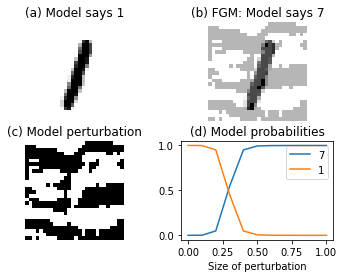

The test label is 5


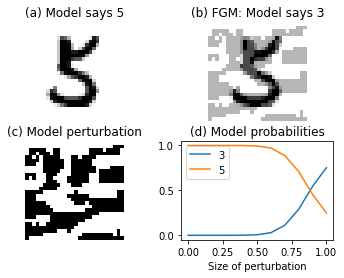

The test label is 3


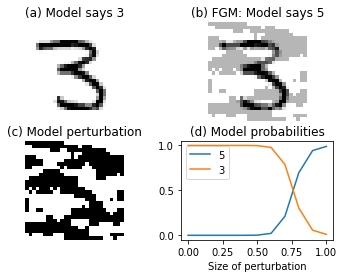

In [10]:
i = 0
for (x, y) in data.test:
    i = i+1
    #while i <= 10 : 
    if i <= 10:
        tf.print("The test label is",y[0])
        x_fgm = fast_gradient_method(model,x,eps, np.inf)
        #x_fgm holds the adversarial example
        y_pred = model(x)
        y_pred_fgm = model(x_fgm)
        #print(y_pred[0])
        #print(y_pred_fgm[0])
        plt.subplot(221)
        plt.imshow(x[0], cmap="binary")
        plt.title("(a) Model says "+str(np.argmax(y_pred[0])))
        plt.axis('off')
        plt.subplot(222)
        plt.imshow(x_fgm[0], cmap="binary")
        plt.title("(b) FGM: Model says "+str(np.argmax(y_pred_fgm[0])))
        plt.axis('off')
        x1 = tf.cast(x, tf.float32)
        y1 = tf.argmax(y_pred, 1)
        grad = compute_gradient(model,loss_fn, x1, y1, targeted)
        optimal_perturbation = optimize_linear(grad, eps, norm)
        plt.subplot(223)
        plt.imshow(optimal_perturbation[0], cmap="binary")
        plt.title("(c) Model perturbation")
        plt.axis('off')
      
        prob_pert=softmax(y_pred[0])[np.argmax(y_pred_fgm[0])]
        prob_fgm = softmax(y_pred_fgm[0])
        prob_pred = softmax(y_pred[0])[np.argmax(y_pred[0])]
                           
        for j in np.arange(1,11) :
            y_pert = model(x+0.1*j*optimal_perturbation)
            prob_pert = np.append(prob_pert,softmax(y_pert[0])[np.argmax(y_pred_fgm[0])])
            prob_pred = np.append(prob_pred,softmax(y_pert[0])[np.argmax(y_pred[0])])
            #prob_fgm.append(softmax(y_pred_fgm[0]))
        #print("Model prediction on intermediate is",softmax(y_pert[0]))
        #print("Model prediction on FGM image is", y_pred_fgm[0])
        #print(prob_pert)
        #print(prob_pred)
        #print(prob_fgm)
        plt.subplot(224)
        t = 0.1*np.arange(0,11)
        plt.plot(t,prob_pert,label=np.argmax(y_pred_fgm[0]))
        plt.plot(t,prob_pred,label=np.argmax(y_pred[0]))
        plt.legend()
        plt.title("(d) Model probabilities")
        ax = plt.gca()
        ax.set_xlabel("Size of perturbation")
        plt.savefig("FGM-example"+str(i)+".png")
        plt.show()
      
    else :
        break

In [ ]:
#adversarial examples using projected gradient descent (PGD) and fast gradient sign(FGM)

The test label is 2


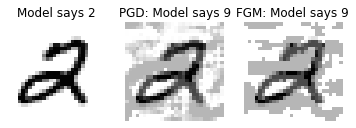

The test label is 2


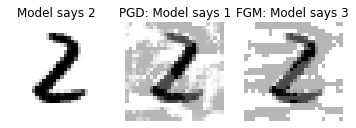

The test label is 3


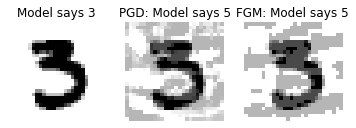

The test label is 6


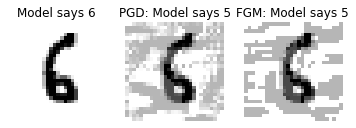

The test label is 1


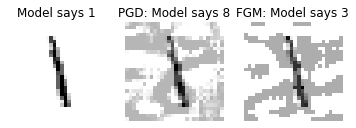

The test label is 8


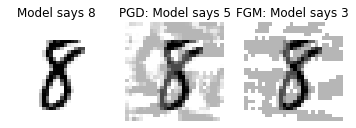

The test label is 8


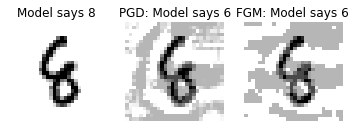

The test label is 1


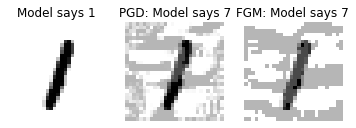

The test label is 5


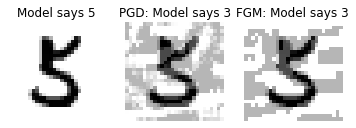

The test label is 3


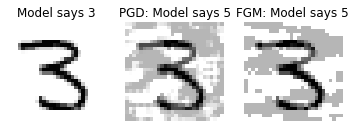

In [11]:
i = 0
for (x, y) in data.test:
    i = i+1
    if i <= 10:
        tf.print("The test label is",y[0])
        x_pgd = projected_gradient_descent(model,x,eps, 0.01, 40, np.inf)
        y_pred = model(x)
        y_pred_pgd = model(x_pgd)
        x_fgm = fast_gradient_method(model,x,eps, np.inf)
        y_pred_fgm = model(x_fgm)
        plt.subplot(131)
        plt.imshow(x[0], cmap="binary")
        plt.title("Model says "+str(np.argmax(y_pred[0])))
        plt.axis('off')
        plt.subplot(132)
        plt.imshow(x_pgd[0], cmap="binary")
        plt.title("PGD: Model says "+str(np.argmax(y_pred_pgd[0])))
        plt.axis('off')
        plt.subplot(133)
        plt.imshow(x_fgm[0], cmap="binary")
        plt.title("FGM: Model says "+str(np.argmax(y_pred_fgm[0])))
        plt.axis('off')
        plt.savefig("PGD-FGM-example"+str(i)+".png")
        plt.show()
    else :
        break

In [ ]:
#Evaluate model accuracy on entire 10000 test cases in all three scenarios :  a) original test data,  b) FGM adversarial version and c) PGD adversarial version. 
#This will take some time

In [12]:
progress_bar_test = tf.keras.utils.Progbar(10000)
for x, y in data.test:
    y_pred = model(x)
    test_acc_clean(y, y_pred)

    x_fgm = fast_gradient_method(model, x, eps, np.inf)
    y_pred_fgm = model(x_fgm)
    test_acc_fgsm(y, y_pred_fgm)

    x_pgd = projected_gradient_descent(model, x,eps, 0.01, 40, np.inf)
    y_pred_pgd = model(x_pgd)
    test_acc_pgd(y, y_pred_pgd)

    progress_bar_test.add(x.shape[0])

print(
    "test acc on clean examples (%): {:.3f}".format(test_acc_clean.result() * 100)
)
print(
    "test acc on FGM adversarial examples (%): {:.3f}".format(
        test_acc_fgsm.result() * 100
    )
)
print(
    "test acc on PGD adversarial examples (%): {:.3f}".format(
        test_acc_pgd.result() * 100
    )
)

10000/10000 [==============================] - 530s 53ms/step
test acc on clean examples (%): 98.920
test acc on FGM adversarial examples (%): 13.920
test acc on PGD adversarial examples (%): 1.070


In [ ]:
# An example result  : 
#test acc on clean examples (%): 98.950
#test acc on FGM adversarial examples (%): 13.810
#test acc on PGD adversarial examples (%): 2.030
#Clearly, the trained model does very poorly on both sets of adversarial examples and it seems the model fares much worse with the PGD examples